In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import AveragePooling2D, Convolution2D, MaxPooling2D, ZeroPadding2D                                
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.models import model_from_json
from keras.regularizers import l2



%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import time
import os, csv
import PIL
from PIL import Image
from numpy import genfromtxt
import pandas as pd

Using Theano backend.


In [2]:
#Load some system specific variables
csvFile = "/Users/chris/Desktop/lisencePlates/LiscencePlateBoxes.csv"
pathToImages = "/Users/chris/Desktop/plates_br-master/images/"
boxes=pd.read_csv(csvFile, sep=',',header=None)
scaledImageSize = (100,100)

In [3]:
#Organize Data so that it is in numpy arrays for the neural network
def changImageSize(fileName):
    img = PIL.Image.open(pathToImages+fileName) #Opens as a color image
    #img = mpimg.imread(pathToImages+fileName) #Opens as a black and white image
    img = img.convert('L') #Converts color image to greyscale
    img = img.resize(scaledImageSize, PIL.Image.ANTIALIAS)
    return img
    
imageData = np.expand_dims(np.empty([100,100]), axis=0)
locationData = np.empty([1,4])
for root, dirs, files in os.walk(pathToImages):
    for fileName in files:
        for i in range(len(boxes)):
            if fileName == boxes[0][i]:
                img = changImageSize(fileName)
                imageData = np.concatenate((imageData, np.expand_dims(np.asarray(img),axis=0)), axis = 0)
                locationData = np.concatenate((locationData,np.expand_dims((np.asarray([boxes[1][i],boxes[2][i],boxes[3][i],boxes[4][i]])), axis = 0)), axis = 0)
imageData = imageData[1:]           #These two lines get ride of the garbage that was
locationData = locationData[1:]     #created in the empty array with np.empty() above

In [4]:
#Check dimensions of everything to make sure shape and datatype is correct
print "imageData Type: ", type(imageData)
print "imageData Shape: ", imageData.shape
print "locationData Type: ", type(locationData)
print "locationData Shape: ", locationData.shape

imageData Type:  <type 'numpy.ndarray'>
imageData Shape:  (93, 100, 100)
locationData Type:  <type 'numpy.ndarray'>
locationData Shape:  (93, 4)


In [5]:
#normalize data
imageData = imageData/255

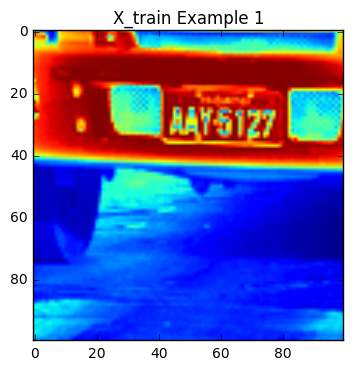

In [6]:
#Print example data to make sure everything looks good
plt.imshow(imageData[0])
plt.title('X_train Example 1')
plt.show()

In [7]:
#divide Data into test and train
imageData = np.expand_dims(imageData, axis=1)
X_train = imageData[:80]
X_test = imageData[80:]
Y_train = locationData[:80]
Y_test = locationData[80:]

In [8]:
im_width = len(X_train[0][0])
im_height = len(X_train[0][0][0])
batch_size = 4
nb_epoch = 100
print "image Width: ", im_width
print "image height: ", im_height

image Width:  100
image height:  100


In [9]:
model = Sequential()
model.add(Convolution2D(64, 10, 10, border_mode='same', input_shape=(1,im_width,im_height)))

model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, 2, 2, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, 2, 2, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, W_regularizer=l2(1e-3)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4)) 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 64, 100, 100)  6464        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 100, 100)  18464       convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 100, 100)  0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 32, 98, 98)    9248        activation_1[0][0]               
___________________________________________________________________________________________

In [ ]:
#Compile the new model
model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

In [ ]:
start = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))
end = time.time()

Train on 80 samples, validate on 13 samples
Epoch 1/100
80/80 [==============================] - 25s - loss: 182257.7426 - acc: 0.4625 - val_loss: 639.9416 - val_acc: 0.1538
Epoch 2/100
80/80 [==============================] - 25s - loss: 681.3463 - acc: 0.4250 - val_loss: 595.3237 - val_acc: 0.1538
Epoch 3/100
80/80 [==============================] - 26s - loss: 697.8592 - acc: 0.4500 - val_loss: 774.8595 - val_acc: 0.1538
Epoch 4/100
80/80 [==============================] - 21s - loss: 651.2601 - acc: 0.4500 - val_loss: 495.9469 - val_acc: 0.1538
Epoch 5/100
80/80 [==============================] - 19s - loss: 680.3162 - acc: 0.4625 - val_loss: 590.1897 - val_acc: 0.1538
Epoch 6/100
80/80 [==============================] - 19s - loss: 670.0845 - acc: 0.4750 - val_loss: 995.4652 - val_acc: 0.1538
Epoch 7/100
80/80 [==============================] - 21s - loss: 969.5763 - acc: 0.4500 - val_loss: 908.5063 - val_acc: 0.1538
Epoch 8/100
80/80 [==============================] - 23s - loss:

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)

print ('Test score:   ', score[0])
print( 'Test accuracy:', score[1])
print( 'Time elapsed: ',(end - start), "seconds")

In [ ]:
print np.expand_dims(imageData, axis=1).shape